In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
from strategy_signal import trend_following_expanded_universe as tf_exp
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(tf_exp)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [8]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [10]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [14]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [16]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD',
   'ICP-USD',
   'CRO-USD',
   'XTZ-USD',
   'FIL-USD',
   'LINK-USD',
   'FET-USD',
   'GRT-USD',
   'OXT-USD',
   'KRL-USD'],
  'sleeves': {'L1_Core': {'weight': 0.5,
    'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
   'L1_Alt': {'weight': 0.15,
    'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
   'AI': {'weight': 0.35,
    'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_t

## Debug Prod Configuration

In [19]:
import datetime
from datetime import datetime, timezone, timedelta
from typing import Iterable
import argparse
import json
import traceback
import itertools
import ast
from strategy_signal.trend_following_signal import (
    get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from utils import stop_loss_cooldown_state as state
from strategy_signal import trend_following_signal as tf
from pathlib import Path
import yaml
import uuid
# from trend_following_email_summary_v020 import send_summary_email

In [21]:
import sys
import importlib.util
from pathlib import Path

strategy_path = Path("/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/trend_following_v0.2.0-live.py").resolve()
sys.path.insert(0, str(strategy_path.parent))

spec = importlib.util.spec_from_file_location("trend_following_v0_2_0_live", strategy_path)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

# now access functions/classes
# mod.some_function(...)

In [23]:
STATE_DIR = Path("/Users/adheerchauhan/Documents/live_strategy_logs/trend_following_v0_2_0-live")
STATE_DIR.mkdir(parents=True, exist_ok=True)
COOLDOWN_STATE_FILE = STATE_DIR / "stop_loss_breach_cooldown_state.json"
COOLDOWN_LOG_FILE   = STATE_DIR / "stop_loss_breach_cooldown_log.jsonl"
DONE_FLAG_DIR       = STATE_DIR / "done_flags"
RUN_LOG             = STATE_DIR / "live_run.log"

# Ensure subdirectories exist
DONE_FLAG_DIR.mkdir(parents=True, exist_ok=True)

# JSONL log files
LIVE_ERRORS_LOG       = STATE_DIR / "live_errors.jsonl"
HEARTBEAT_LOG         = STATE_DIR / "heartbeat.jsonl"
DESIRED_TRADES_LOG    = STATE_DIR / "desired_trades_log.jsonl"
ORDER_BUILD_LOG       = STATE_DIR / "order_build_log.jsonl"
ORDER_SUBMIT_LOG      = STATE_DIR / "order_submit_log.jsonl"
DUST_BUILD_LOG        = STATE_DIR / "dust_build_log.jsonl"
DUST_SUBMIT_LOG       = STATE_DIR / "dust_submit_log.jsonl"
STOP_UPDATE_LOG       = STATE_DIR / "stop_update_log.jsonl"
DAILY_SUMMARY_DIR = STATE_DIR / "daily_summaries"
DAILY_SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

CURRENT_RUN_ID = None

def new_run_id(now_utc=None) -> str:
    now_utc = now_utc or utc_now()
    return now_utc.strftime("%Y-%m-%dT%H%M%SZ") + "-" + uuid.uuid4().hex[:8]

def set_run_id(run_id: str):
    global CURRENT_RUN_ID
    CURRENT_RUN_ID = run_id

def daily_summary_path(day) -> Path:
    return DAILY_SUMMARY_DIR / f"daily_summary_{day.isoformat()}.json"


def utc_now():
    return datetime.now(timezone.utc)


def _utc_ts(d):
    """UTC tz-aware Timestamp (00:00Z if 'd' is a date)."""
    ts = pd.Timestamp(d)
    return ts.tz_localize('UTC') if ts.tzinfo is None else ts.tz_convert('UTC')


def utc_now_iso():
    return datetime.now(timezone.utc).isoformat()


def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--force-run", action="store_true")
    ap.add_argument("--run-at-utc-hour", type=int, default=0)
    ap.add_argument("--gate-minutes", type=int, default=5)
    ap.add_argument("--dry-run", action="store_true")

    return ap.parse_args()

In [25]:
# args = parse_args()
now = utc_now()
today = now.date()

# Generate Run Id for the run and log start time
run_id = new_run_id(now)
set_run_id(run_id)
started_at = utc_now_iso()
run_errors = []
stop_results = {}

In [27]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')
portfolio_name = cfg['portfolio']['name']
ticker_list = cfg['universe']['tickers']
sleeve_budgets = cfg['universe']['sleeves']
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [29]:
## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve

In [31]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
_ = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)  # validate

In [33]:
date = today

In [35]:
today

datetime.date(2026, 1, 27)

In [37]:
df, desired_positions, current_positions = mod.get_desired_trades_by_ticker(client, cfg, date=today)

Generating Volatility Adjusted Trend Signal!!
Covariance Matrix Time: 2026-01-26 21:25:04.764188
Start Time: 2026-01-26 21:25:04.796684
Get Portfolio Equity and Cash Time: 2026-01-26 21:25:04.924914
Get Current Positions Time: 2026-01-26 21:25:05.257014
Target Volatility Position Sizing Time: 2026-01-26 21:25:21.076310


In [39]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 88516.345,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 2933.205,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 124.38,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.3532,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 11.785,
  'ticker_current_notional': 0.0},
 'ICP-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3.3395,
  'ticker_current_notional': 0.0},
 'CRO-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.090885,
  'ticker_current_notional': 0.0},
 'XTZ-USD': {'ticker_qty': 0.01,
  'ticker_mid_price': 0.5674,
  'ticker_current_notional': 0.005674},
 'FIL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 1.2774999999999999,
  'ticker_current_notional': 0.0},
 'LINK-USD': {'ticker_qty': 0,
  'ticker_mid_price': 11.9865,
  'ticker_current_notional': 0.0},
 'FET-USD': {'ticker

In [41]:
desired_positions

{'BTC-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ETH-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'SOL-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ADA-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'AVAX-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ICP-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'CRO-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'XTZ-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'FIL-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'LINK-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'FET-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'GRT-USD': {'new_t

In [43]:
df.tail()

,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_cash_shrink_factor,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_data_ok,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_sleeve_risk_adj_weights,BTC-USD_sleeve_risk_multiplier,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_cash_shrink_factor,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_data_ok,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_sleeve_risk_adj_weights,ETH-USD_sleeve_risk_multiplier,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_cash_shrink_factor,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_data_ok,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_sleeve_risk_adj_weights,SOL-USD_sleeve_risk_multiplier,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_cash_shrink_factor,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_data_ok,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_sleeve_risk_adj_weights,ADA-USD_sleeve_risk_multiplier,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_cash_shrink_factor,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_data_ok,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_sleeve_risk_adj_weights,AVAX-USD_sleeve_risk_multiplier,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_cash_shrink_factor,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_data_ok,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_new_position_entry_exit_price,ICP-USD_new_position_notional,ICP-USD_open,ICP-USD_open_position_notional,ICP-USD_open_position_size,ICP-USD_short_sale_proceeds,ICP-USD_sleeve_risk_adj_weights,ICP-USD_sleeve_risk_multiplier,ICP-USD_stop_loss,ICP-USD_stopout_flag,ICP-USD_t_1_close,ICP-USD_t_1_close_pc

## Backtest Config Tracking

In [84]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

portfolio_name = cfg['portfolio']['name']
ticker_list = list(cfg['universe']['tickers'])

## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve
risk_min_signal = float(cfg['risk_and_sizing']['risk_min_signal'])
sleeve_risk_mode = str(cfg['risk_and_sizing']['sleeve_risk_mode']).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing']['risk_sleeve_budget_tolerance'])
risk_optimizer_step = float(cfg['risk_and_sizing']['risk_optimizer_step'])
risk_max_iterations = int(cfg['risk_and_sizing']['risk_max_iterations'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

risk_min_signal = float(cfg['risk_and_sizing'].get('risk_min_signal', 1e-4))
sleeve_risk_mode = str(cfg['risk_and_sizing'].get('sleeve_risk_mode', 'cap')).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing'].get('risk_sleeve_budget_tolerance', 1e-5))
risk_optimizer_step = float(cfg['risk_and_sizing'].get('risk_optimizer_step', 0.5))
risk_max_iterations = int(cfg['risk_and_sizing'].get('risk_max_iterations', 100))
cap_mode = str(cfg['risk_and_sizing'].get('cap_mode', 'conditional')).strip().lower()
cap_low = float(cfg['risk_and_sizing'].get('cap_low', 0.35))
cap_high = float(cfg['risk_and_sizing'].get('cap_high', 0.60))
cap_n_eff_threshold = float(cfg['risk_and_sizing'].get('cap_n_eff_threshold', 2.0))
cap_use_metric = str(cfg['risk_and_sizing'].get('cap_use_metric', 'rb_n_eff')).strip().lower()
cap_max_iter = int(cfg['risk_and_sizing'].get('cap_max_iter', 20))
cap_tol = float(cfg['risk_and_sizing'].get('cap_tol', 1e-10))

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [86]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [88]:
print(start_date, end_date)

2022-04-01 2026-01-27


In [90]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name)
df_portfolio_positions = cn.get_portfolio_breakdown(client, portfolio_uuid)

In [94]:
# ----- 1) backtest -----
df_expanded_universe_with_conditional_name_cap = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode,

    # ---- conditional cap params (GRID) ----
    cap_mode=cap_mode,
    cap_low=cap_low,
    cap_high=cap_high,
    cap_n_eff_threshold=cap_n_eff_threshold,
    cap_use_metric=cap_use_metric,
    cap_max_iter=cap_max_iter,
    cap_tol=cap_tol,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


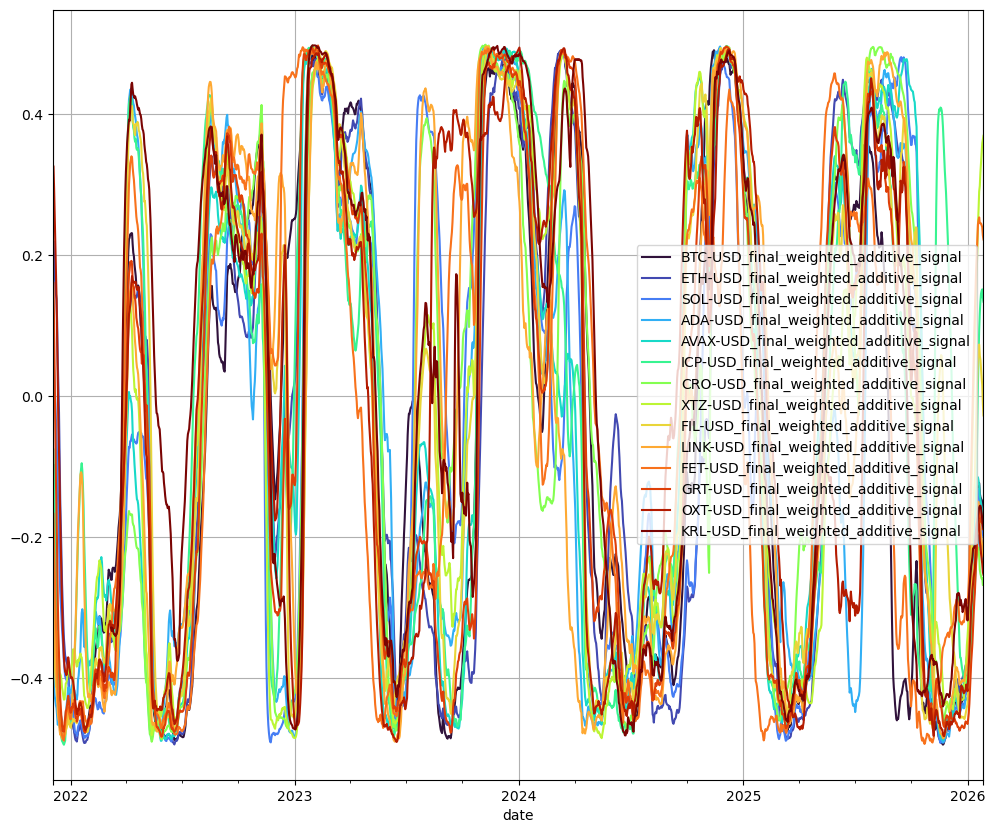

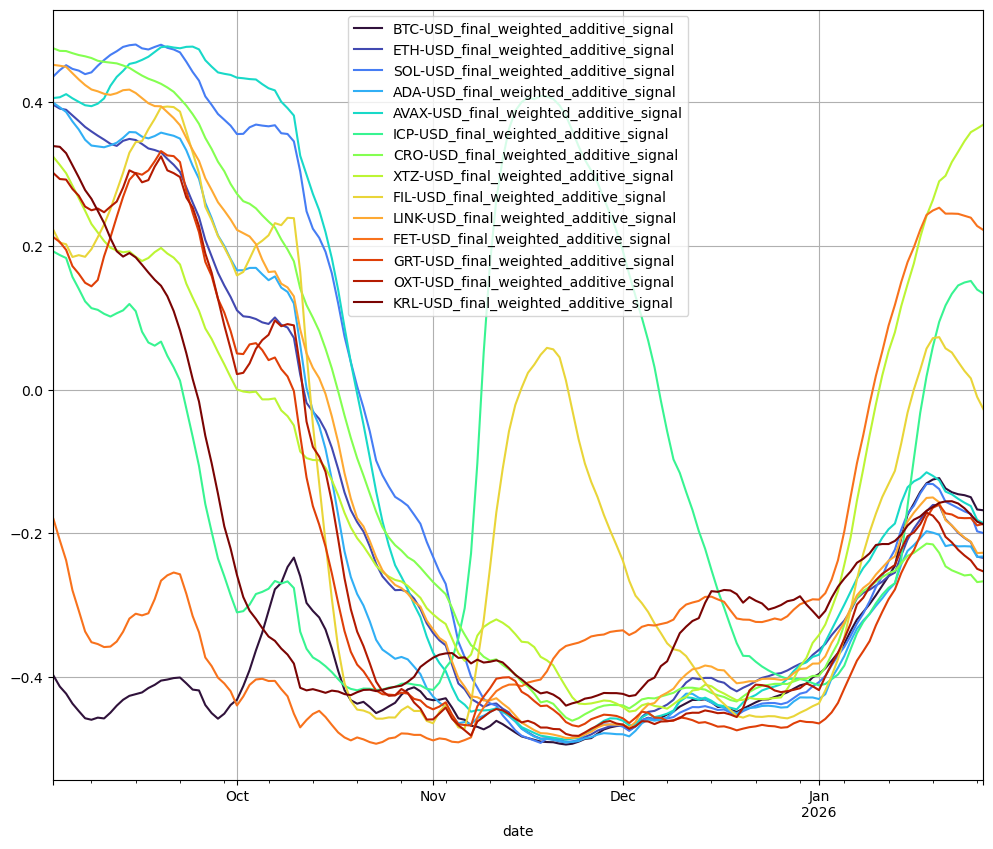

In [98]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_final_weighted_additive_signal' for t in ticker_list]
date_cond = df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe_with_conditional_name_cap[raw_signal_cols].plot(figsize=(12,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, raw_signal_cols].plot(figsize=(12,10), grid=True, color=colors, linewidth=1.5)
plt.show()


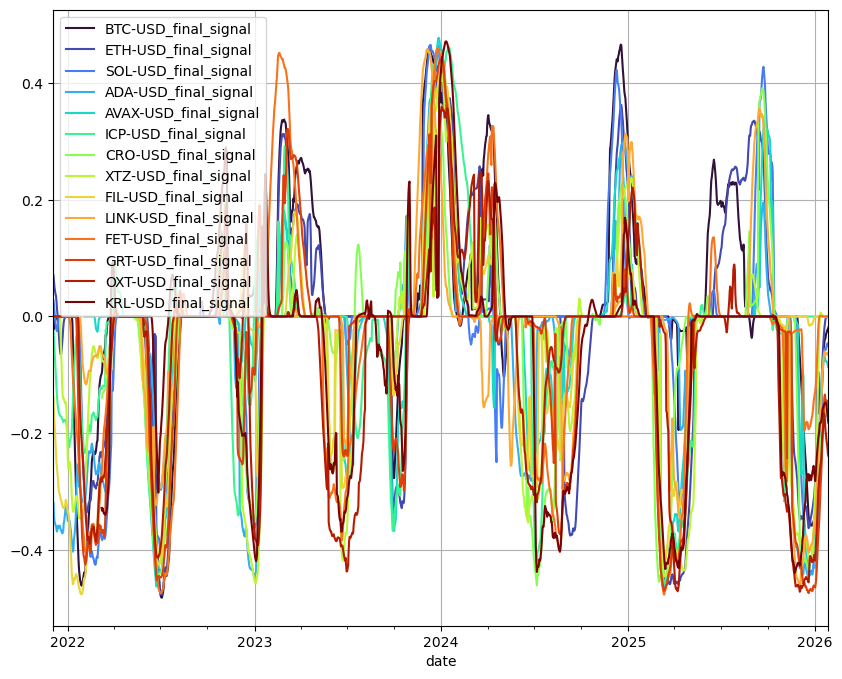

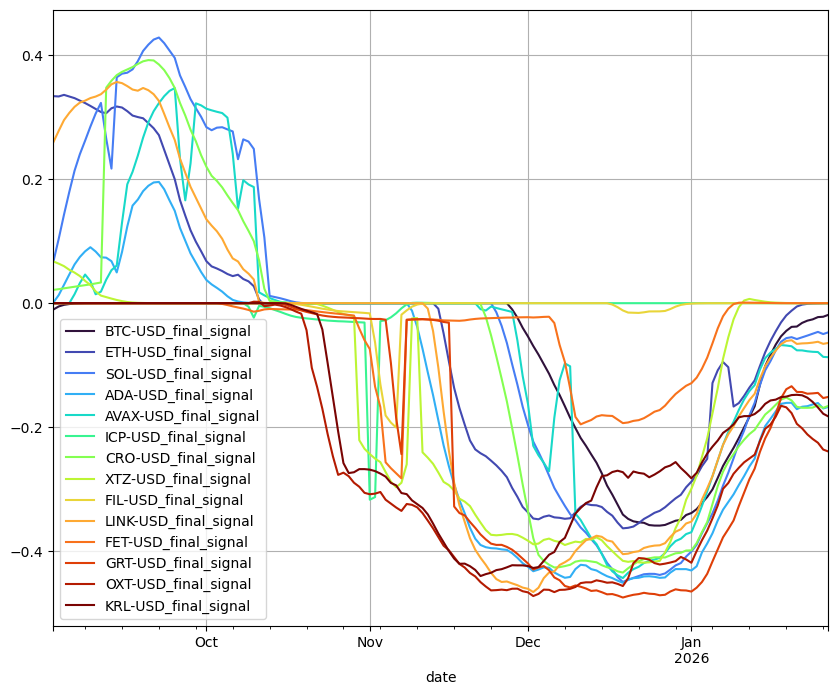

In [100]:
## Signal after Regime Filtering and Before Volatility Adjusting
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[final_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, final_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

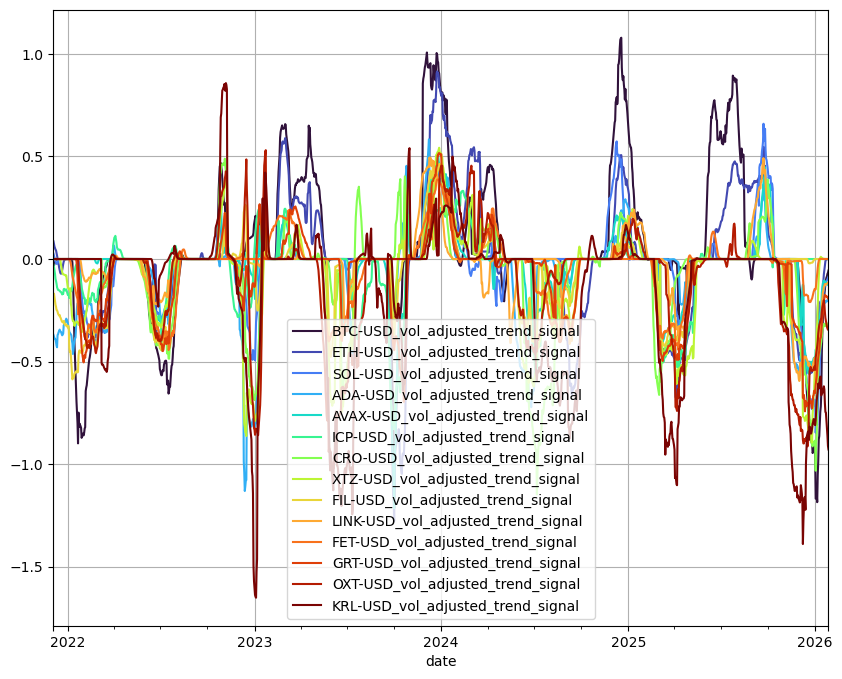

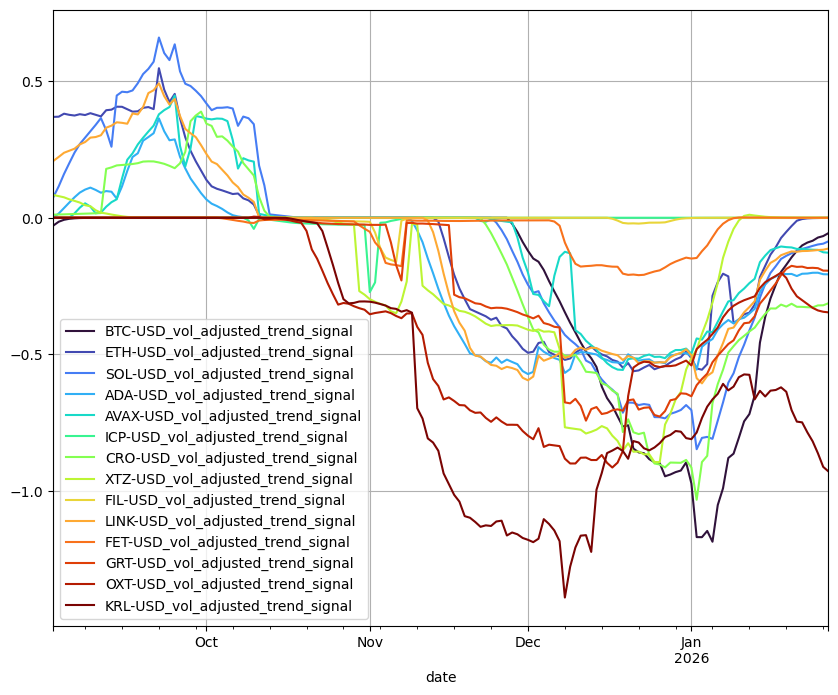

In [102]:
## Signal after Volatility Adjusting
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[vol_adj_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, vol_adj_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

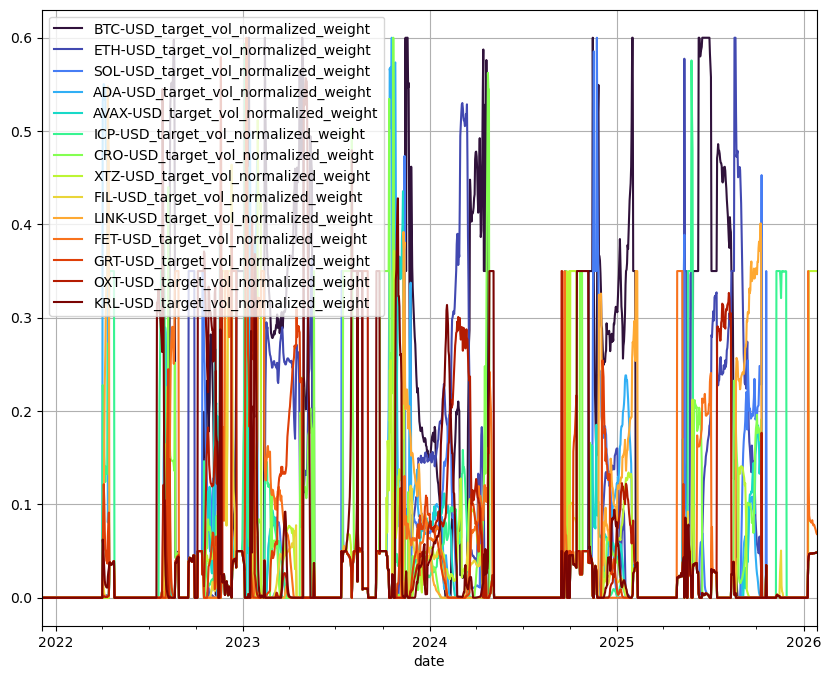

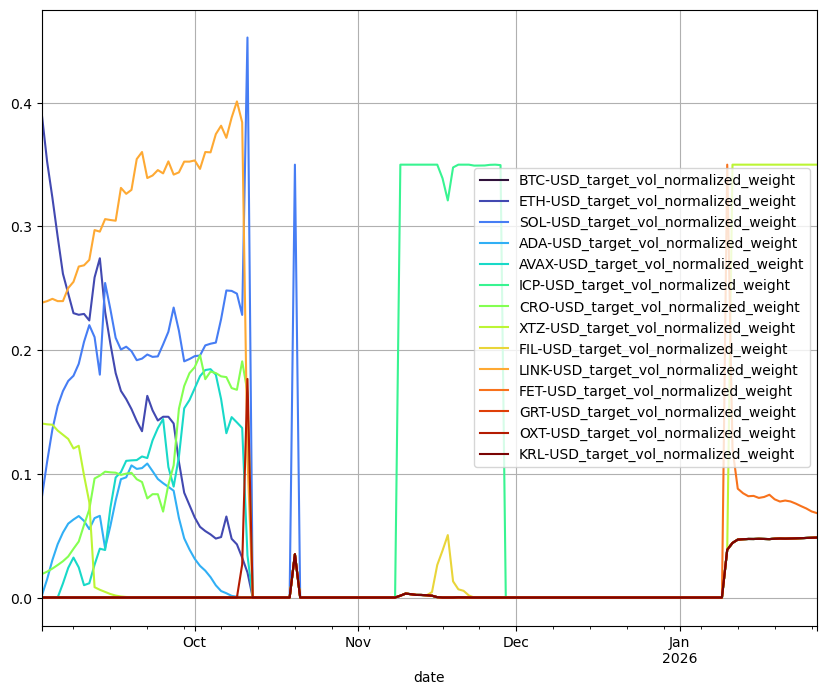

In [104]:
## Signal after Volatility Adjusting
target_vol_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[target_vol_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, target_vol_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

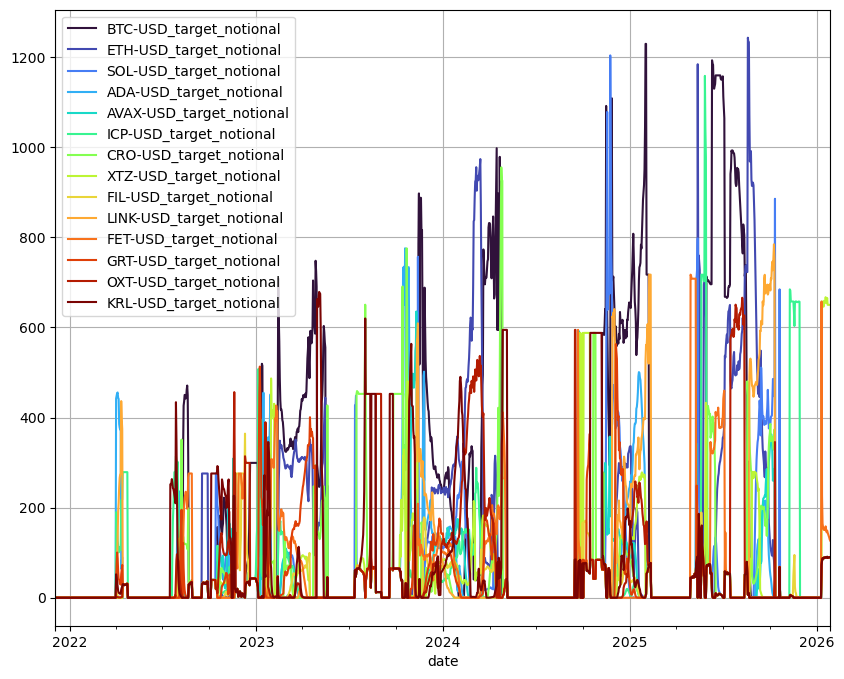

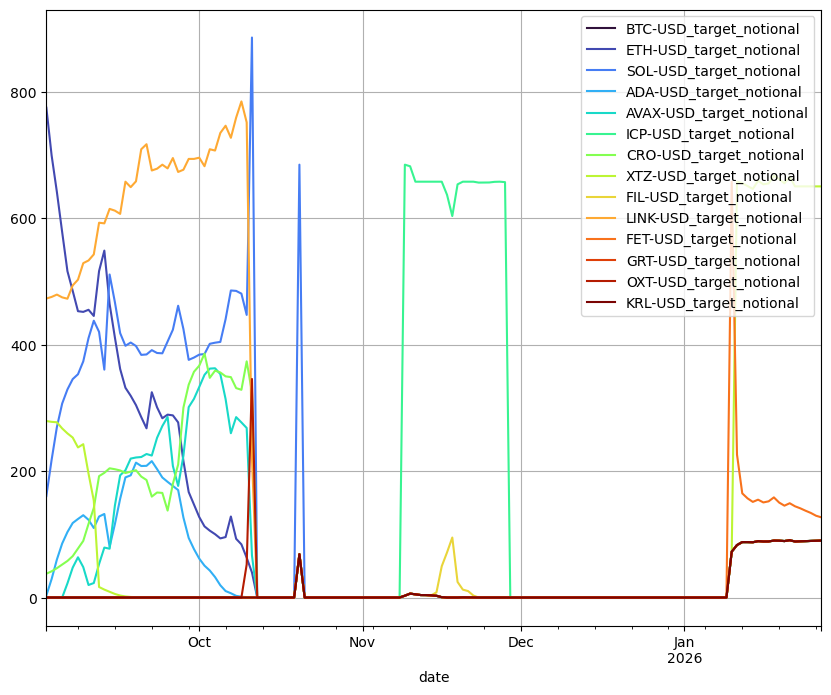

In [106]:
## Signal after Volatility Adjusting
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[target_notional_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, target_notional_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()